### Building Chatbot with Multiple Tools 

- Aim - Create a chatbot with tool capabilities from arxiv, wikipedia and tavily search

In [18]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

#### Arxiv Wrapper

In [19]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max = 500)
arxiv= ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [20]:
arxiv.invoke("Transformer in machine learning")

'Published: 2023-06-07\nTitle: Changing Data Sources in the Age of Machine Learning for Official Statistics\nAuthors: Cedric De Boom, Michael Reusens\nSummary: Data science has become increasingly essential for the production of official statistics, as it enables the automated collection, processing, and analysis of large amounts of data. With such data science practices in place, it enables more timely, more insightful and more flexible reporting. However, the quality and integrity of data-science-'

#### Wikipedia Wrapper

In [21]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max = 500)
wiki= WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [22]:
wiki.invoke("Transformer in machine learning")

'Page: Transformer (deep learning)\nSummary: In deep learning, the transformer is an artificial neural network architecture based on the multi-head attention mechanism, in which text is converted to numerical representations called tokens, and each token is converted into a vector via lookup from a word embedding table. At each layer, each token is then contextualized within the scope of the context window with other (unmasked) tokens via a parallel multi-head attention mechanism, allowing the sig'

#### Tavily Wrapper

In [23]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [24]:
### Tavily Search Tool

from langchain_community.tools import TavilySearchResults
tavily = TavilySearchResults()

In [25]:
tavily.invoke("Latest research on transformers in machine learning on 20th November 2025")

[{'title': 'Beyond Standard LLMs (Sebastian Taschka, November 2025, 20mn ...',
  'url': 'https://www.facebook.com/groups/DeepNetGroup/posts/2644531075939758/',
  'content': 'The Transformer architecture has become the primary deep-learning model used for NLP research. Recent efforts have focused on increasing the',
  'score': 0.99935883},
 {'title': 'Attention Is All You Need - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Attention_Is_All_You_Need',
  'content': 'Since 2020, transformers have been applied in modalities beyond text, including the vision transformer, speech recognition, robotics, and multimodal. The vision transformer, in turn, stimulated new developments in convolutional neural networks. Image and video generators like DALL-E (2021), Stable Diffusion 3 (2024), and Sora "Sora (text-to-video model)") (2024), use transformers to analyse input data (like text prompts) by breaking it down into "tokens" and then calculating the relevance [...] "Attention Is All You Nee

### Combine all tools in a list

In [26]:
tools = [arxiv, wiki, tavily]

In [27]:
## Initialize the LLM Model

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

llm_with_tools = llm.bind_tools(tools)

In [28]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

llm_with_tools.invoke([HumanMessage(content="Provide me with a summary of the latest research on transformers in machine learning." )])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'x9dgzkt50', 'function': {'arguments': '{"query":"latest research on transformers in machine learning"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 562, 'total_tokens': 583, 'completion_time': 0.07896932, 'prompt_time': 0.043529402, 'queue_time': 0.056883917, 'total_time': 0.122498722}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--d6e5f3f4-b812-44ad-9a28-4d5338a67ca9-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'latest research on transformers in machine learning'}, 'id': 'x9dgzkt50', 'type': 'tool_call'}], usage_metadata={'input_tokens': 562, 'output_tokens': 21, 'total_tokens': 583})

### Construct our graph

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

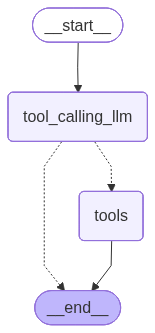

In [32]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state):
    return {"messages" : (llm_with_tools.invoke(state["messages"]))}

# Build graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm" , tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
messages = graph.invoke({"messages" : HumanMessage(content="1706.03762")})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (g88g64heh)
 Call ID: g88g64heh
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base
